In [1]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Uso de GPU (Local)
import torch                                                                   # Librería principal de PyTorch
from torch import cuda                                                         # Librería para trabajar con GPU
USE_GPU = torch.cuda.is_available()                                            # Activar uso de GPU
device = torch.device('cuda' if USE_GPU else 'cpu')                            # Dispositivo (GPU o CPU)
print("GPU de uso: ", torch.cuda.get_device_name())

# Importación librerías
import os                                                                      # Librería para interactuar con el sistema operativo
import pandas as pd                                                            # Librería para manipulación de datos
import matplotlib.pyplot as plt                                                # Librería para visualización de datos
import seaborn as sns                                                          # Librería para visualización de datos
import numpy as np                                                             # Librería para manipulación de arrays y matrices

from sklearn.model_selection import train_test_split                           # División de datos en entrenamiento y prueba
from sklearn.feature_extraction.text import CountVectorizer                    # Vectorización de texto
from sklearn.preprocessing import MultiLabelBinarizer                          # Binarización de etiquetas múltiples
from sklearn.multiclass import OneVsRestClassifier                             # Vectorización de etiquetas múltiples
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier     # Modelos de bosque aleatorio
from sklearn.linear_model import LogisticRegression                            # Regresión logística
from sklearn.metrics import r2_score, roc_auc_score                            # Métricas de evaluación

import torch.nn as nn                                                          # Redes neuronales
import torch.optim as optim                                                    # Optimizadores de PyTorch
from torch.utils.data import DataLoader, TensorDataset                         # Cargador de datos de PyTorch

GPU de uso:  NVIDIA GeForce RTX 3090 Ti


In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [4]:
# Verifica que son listas
print(type(dataTraining['genres'].iloc[0]))  # Debe decir: <class 'str'> o <class 'list'>

# Si los géneros están como strings, convertirlos a listas
if isinstance(dataTraining['genres'].iloc[0], str):
    dataTraining['genres'] = dataTraining['genres'].apply(eval)

<class 'str'>


In [5]:
# Binarizar
mlb = MultiLabelBinarizer()
y_genres = mlb.fit_transform(dataTraining['genres'])

In [6]:
# 3. Generate BERT embeddings (this is the part you were missing)
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Generate embeddings for training data
dataTraining['plot_clean_bert'] = dataTraining['plot'].progress_apply(get_bert_embeddings)

# Generate embeddings for test data (important!)
dataTesting['plot_clean_bert'] = dataTesting['plot'].progress_apply(get_bert_embeddings)

# 4. Now proceed with your model
X = np.vstack(dataTraining['plot_clean_bert'].values)
y = y_genres

# Rest of your model code...
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

100%|██████████| 3383/3383 [00:17<00:00, 196.96it/s]


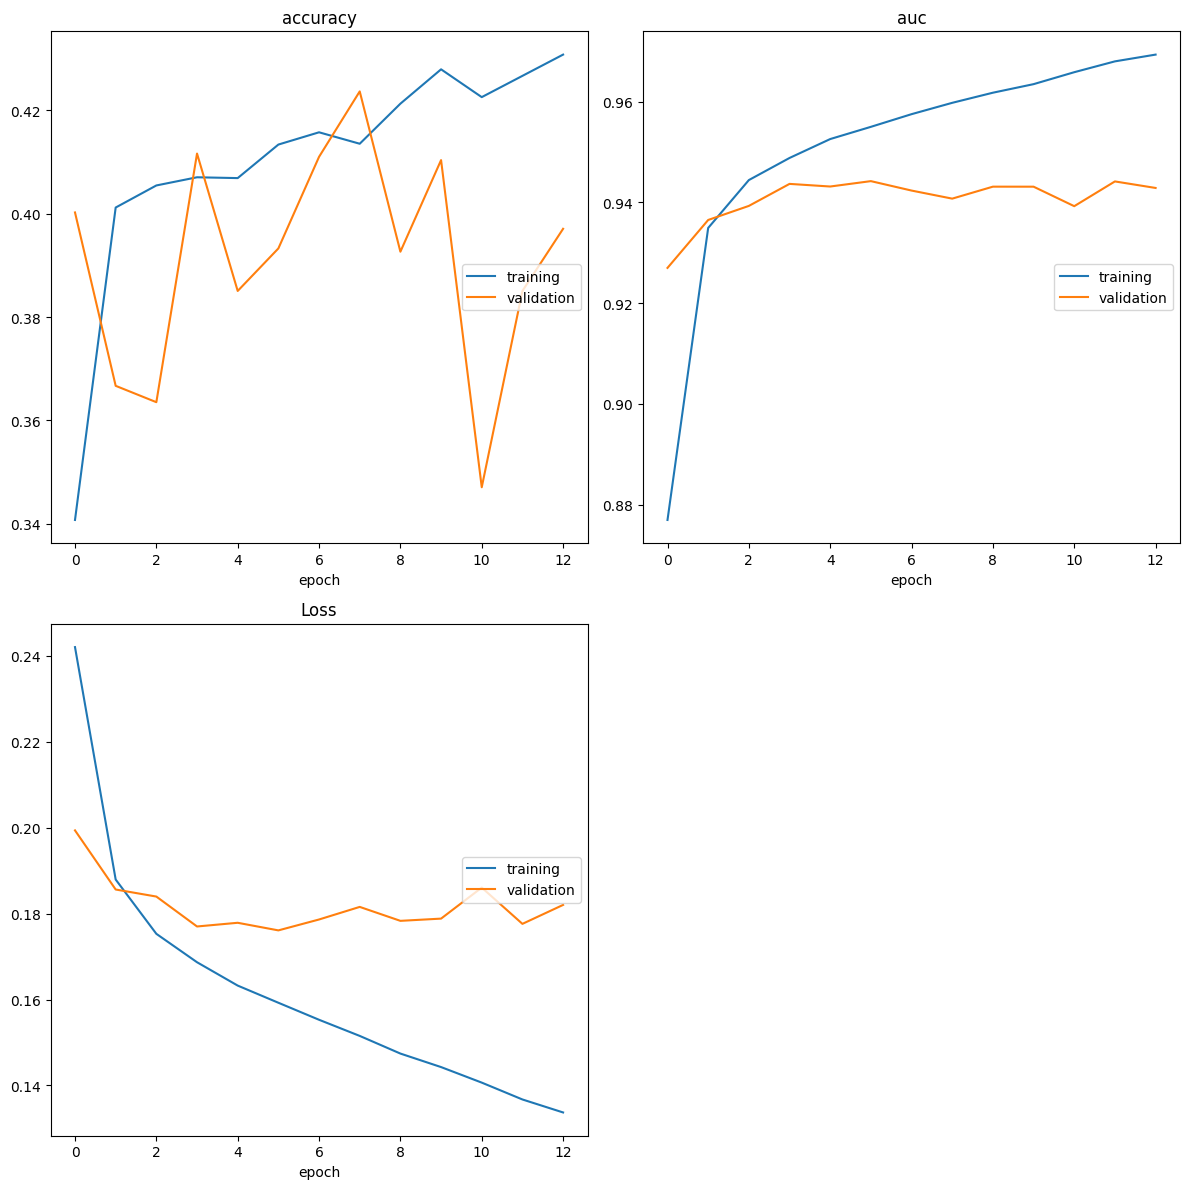

accuracy
	training         	 (min:    0.341, max:    0.431, cur:    0.431)
	validation       	 (min:    0.347, max:    0.424, cur:    0.397)
auc
	training         	 (min:    0.877, max:    0.969, cur:    0.969)
	validation       	 (min:    0.927, max:    0.944, cur:    0.943)
Loss
	training         	 (min:    0.134, max:    0.242, cur:    0.134)
	validation       	 (min:    0.176, max:    0.199, cur:    0.182)
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4317 - auc: 0.9695 - loss: 0.1331 - val_accuracy: 0.3971 - val_auc: 0.9429 - val_loss: 0.1820

Evaluación en conjunto de validación:
Loss: 0.1761, Accuracy: 0.3933, AUC: 0.9442
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
Modelo guardado como modelo_nn.keras


In [14]:
# Definición de dimensiones de salida (variables de interés)
output_var = y_train.shape[1]
print(output_var, 'output variables')

# Definición de dimensiones de entrada (variables predictoras)
dims = X_train.shape[1]
print(dims, 'input variables')

# Importación librerías
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras
import tensorflow as tf

# Configuración de GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible y configurada")
else:
    print("No se encontró GPU, usando CPU")

# Definición de función que crea la red neuronal
def nn_model_params(optimizer='adam',
                   neurons=128,
                   batch_size=32,
                   epochs=50,
                   activation='relu',
                   patience=5,
                   loss='binary_crossentropy'):
    
    K.clear_session()

    model = Sequential()
    
    # Capa de entrada y primera capa oculta
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    # Segunda capa oculta
    model.add(Dense(neurons, activation=activation))
    # Capa de salida (usamos sigmoid para clasificación multi-etiqueta)
    model.add(Dense(output_var, activation='sigmoid'))

    # Compilación del modelo
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy', metrics.AUC(name='auc')])
    
    # Early Stopping
    early_stopping = EarlyStopping(monitor="val_loss",
                                 patience=patience,
                                 restore_best_weights=True)

    # Entrenamiento del modelo
    history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[early_stopping, PlotLossesKeras()],
                       verbose=1)
    
    return model, history

# Parámetros del modelo
params = {
    'optimizer': Adam(learning_rate=0.001),
    'neurons': 256,  # Aumentado para manejar embeddings BERT
    'batch_size': 32,
    'epochs': 100,
    'activation': 'relu',
    'patience': 7,  # Paciencia mayor para embeddings profundos
    'loss': 'binary_crossentropy'
}

# Entrenamiento del modelo
model, history = nn_model_params(**params)

# Evaluación del modelo
print("\nEvaluación en conjunto de validación:")
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

# Predicción en el conjunto de prueba
y_pred_test = model.predict(np.vstack(dataTesting['plot_clean_bert'].values))

# Guardar el modelo
model.save('modelo_nn.keras')
print("Modelo guardado como modelo_nn.keras")

## Aplicación del modelo a datos de test

In [15]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [19]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_NN_RSearch.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.011004,0.039019,0.001225,0.013192,0.047591,0.051490,0.000303,0.798318,0.007498,0.049973,...,0.005471,0.227751,0.000162,0.625554,0.011807,0.001448,0.000195,0.330595,0.003168,0.027581
4,0.438540,0.019334,0.000598,0.097730,0.095560,0.510370,0.009953,0.739351,0.000802,0.000202,...,0.000789,0.005452,0.000580,0.111472,0.000197,0.000537,0.036666,0.430095,0.004402,0.000440
5,0.103674,0.009393,0.000147,0.061995,0.059885,0.829392,0.001562,0.768760,0.001038,0.004973,...,0.001412,0.326433,0.000381,0.108628,0.007908,0.000492,0.002403,0.770463,0.001793,0.004510
6,0.462691,0.392763,0.001958,0.006737,0.273467,0.072095,0.000128,0.503158,0.004931,0.008186,...,0.008995,0.011543,0.000161,0.264269,0.095254,0.000879,0.004134,0.489079,0.180566,0.001935
7,0.008207,0.008888,0.004085,0.007168,0.092684,0.024034,0.000936,0.156173,0.004247,0.079590,...,0.008551,0.157933,0.000203,0.152253,0.775795,0.008815,0.000035,0.305314,0.000236,0.000305
